In [42]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn.tree import DecisionTreeClassifier, plot_tree
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.metrics.pairwise import pairwise_distances  # Import pairwise_distances
from sklearn.mixture import GaussianMixture  # Import GaussianMixture
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

Column Names:
Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')


Dimensions:
(1453, 15)


First 3 rows:
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


Rounded Column Means:
yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy    

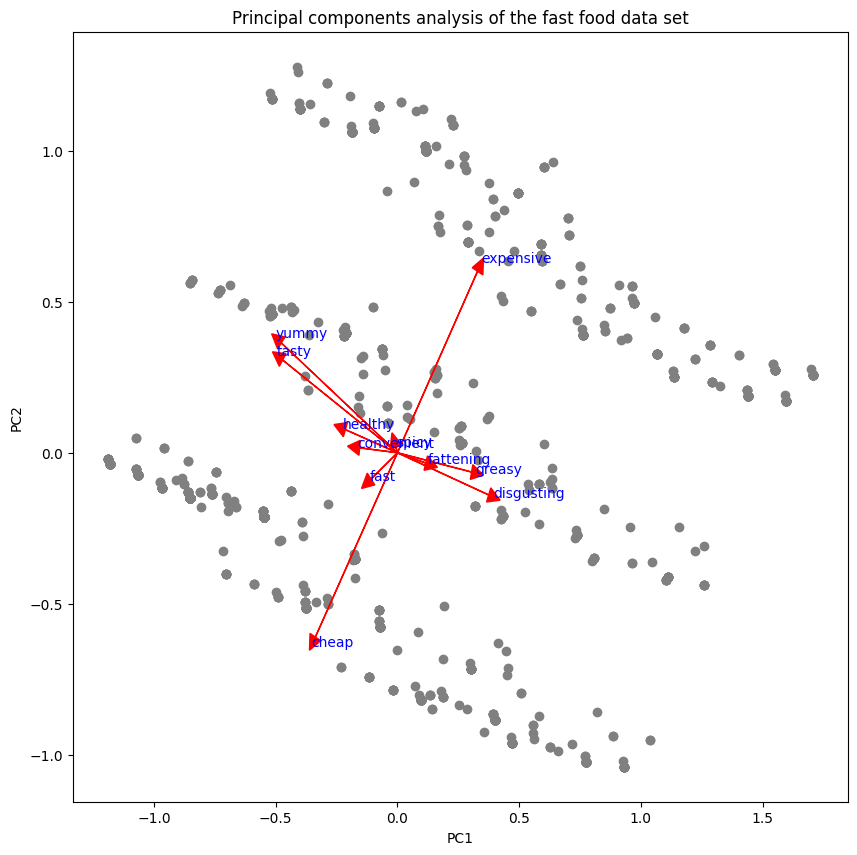

In [29]:
# Load data
mcdonalds = pd.read_csv("/kaggle/input/mcdolands-fast-food/mcdonalds.csv")

# Description: Display column names
print("Column Names:")
print(mcdonalds.columns)
print("\n")

# Description: Display dimensions
print("Dimensions:")
print(mcdonalds.shape)
print("\n")

# Description: Display first 3 rows
print("First 3 rows:")
print(mcdonalds.head(3))
print("\n")

# Extract features for PCA
MD_x = mcdonalds.iloc[:, :11]
MD_x = (MD_x == "Yes").astype(int)

# Description: Display rounded column means
print("Rounded Column Means:")
print(np.round(MD_x.mean(), 2))
print("\n")

# Perform PCA
MD_pca = PCA()
MD_pca.fit(MD_x)

# Description: Display summary of PCA
print("PCA Summary:")
print("Importance of components:")
print(pd.DataFrame({
    "Standard deviation": np.round(MD_pca.explained_variance_, 4),
    "Proportion of Variance": np.round(MD_pca.explained_variance_ratio_, 4),
    "Cumulative Proportion": np.round(np.cumsum(MD_pca.explained_variance_ratio_), 4)
}, index=[f"PC{i+1}" for i in range(len(MD_pca.explained_variance_))]))
print("\n")

# Description: Display PCA components
print("PCA Components:")
print("Rotation (n x k) = (11 x 11):")
print(pd.DataFrame(np.round(MD_pca.components_, 2), columns=MD_x.columns))
print("\n")

# Plot PCA
plt.scatter(MD_pca.transform(MD_x)[:, 0], MD_pca.transform(MD_x)[:, 1], color="grey")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Principal components analysis of the fast food data set")

# Description: Annotate plot with arrows indicating directions of features
for i, feature in enumerate(MD_x.columns):
    plt.arrow(0, 0, MD_pca.components_[0, i], MD_pca.components_[1, i], color='red', head_width=0.05, head_length=0.05)
    plt.text(MD_pca.components_[0, i]*1.05, MD_pca.components_[1, i]*1.05, feature, color='blue')

plt.show()


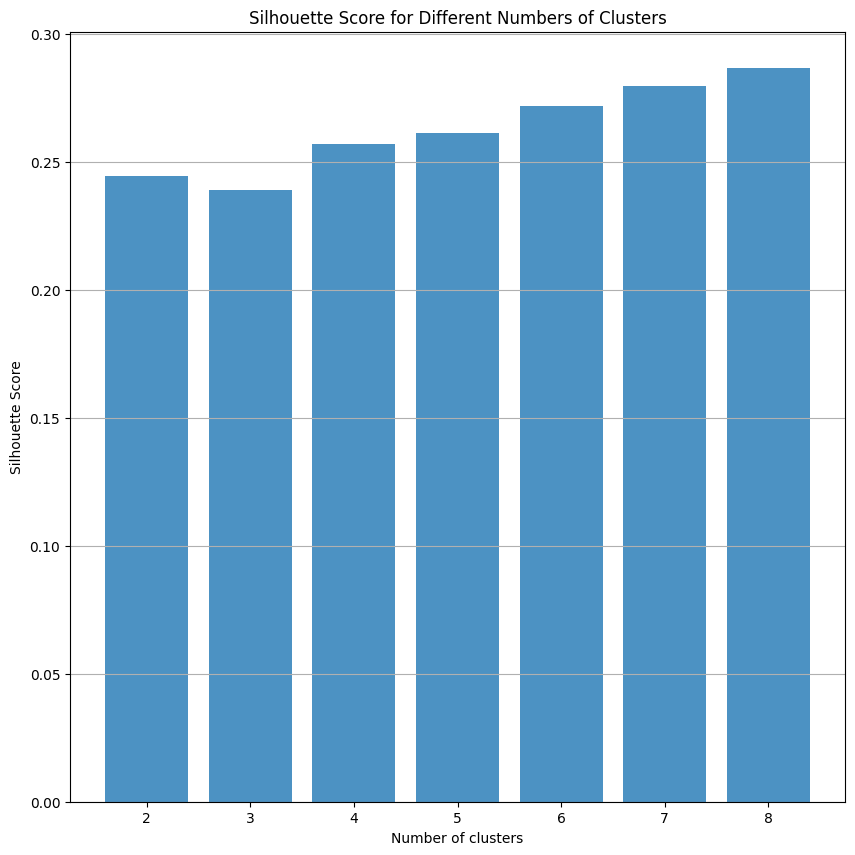

In [31]:
# Set random seed
np.random.seed(1234)

# Perform stepwise k-means clustering
k_range = range(2, 9)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    silhouette_scores.append(silhouette_score(MD_x, kmeans.labels_))

# Plot silhouette scores in a bar graph
plt.bar(k_range, silhouette_scores, align='center', alpha=0.8)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.xticks(k_range)
plt.grid(axis='y')
plt.show()

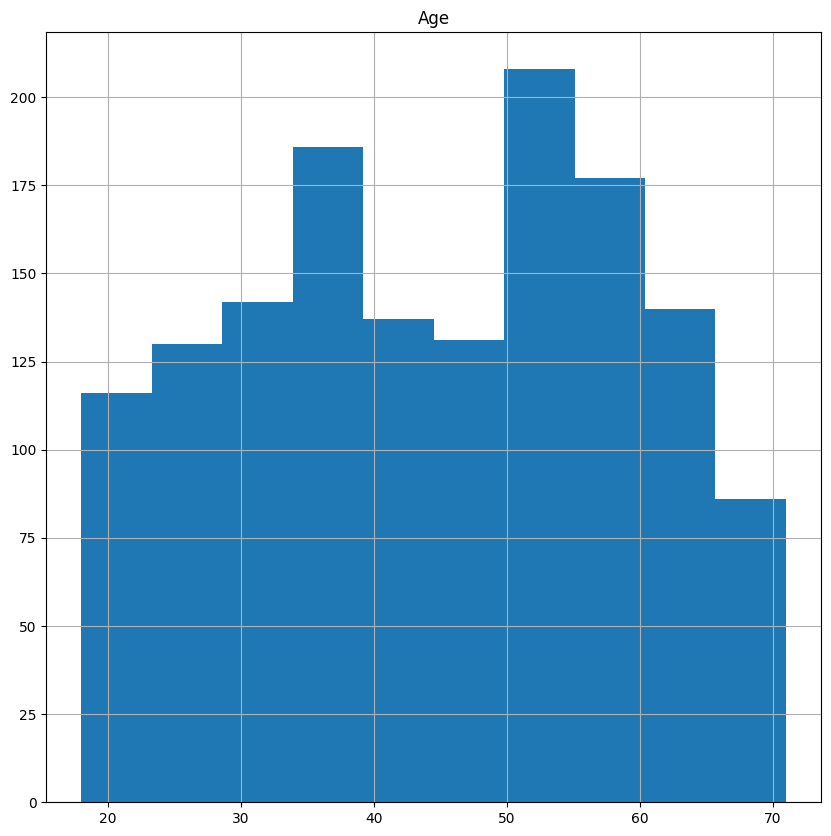

In [32]:
# Set figure size
plt.rcParams['figure.figsize'] = (10, 10)

# Plot histogram of each attribute
mcdonalds.hist()
plt.show()

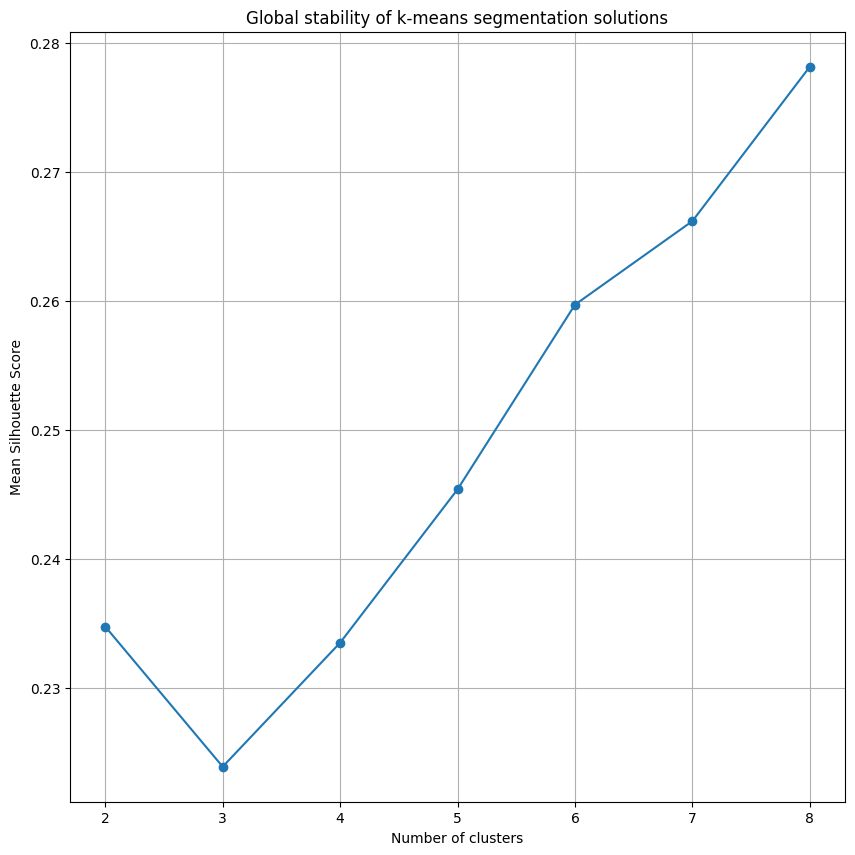

In [33]:
# Set random seed
np.random.seed(1234)

# Perform bootstrapped k-means clustering
n_boot = 100
silhouette_scores_boot = []

for k in k_range:
    silhouette_scores_iter = []
    for _ in range(n_boot):
        # Sample with replacement
        sample_indices = np.random.choice(range(len(MD_x)), len(MD_x), replace=True)
        sample_data = MD_x.values[sample_indices]
        
        # Fit k-means on sampled data
        kmeans = KMeans(n_clusters=k, n_init=1, random_state=1234)
        kmeans.fit(sample_data)
        silhouette_scores_iter.append(silhouette_score(sample_data, kmeans.labels_))
    
    # Calculate mean silhouette score across iterations
    silhouette_scores_boot.append(np.mean(silhouette_scores_iter))

# Plot global stability
plt.plot(k_range, silhouette_scores_boot, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Mean Silhouette Score")
plt.title("Global stability of k-means segmentation solutions")
plt.xticks(k_range)
plt.grid(True)
plt.show()

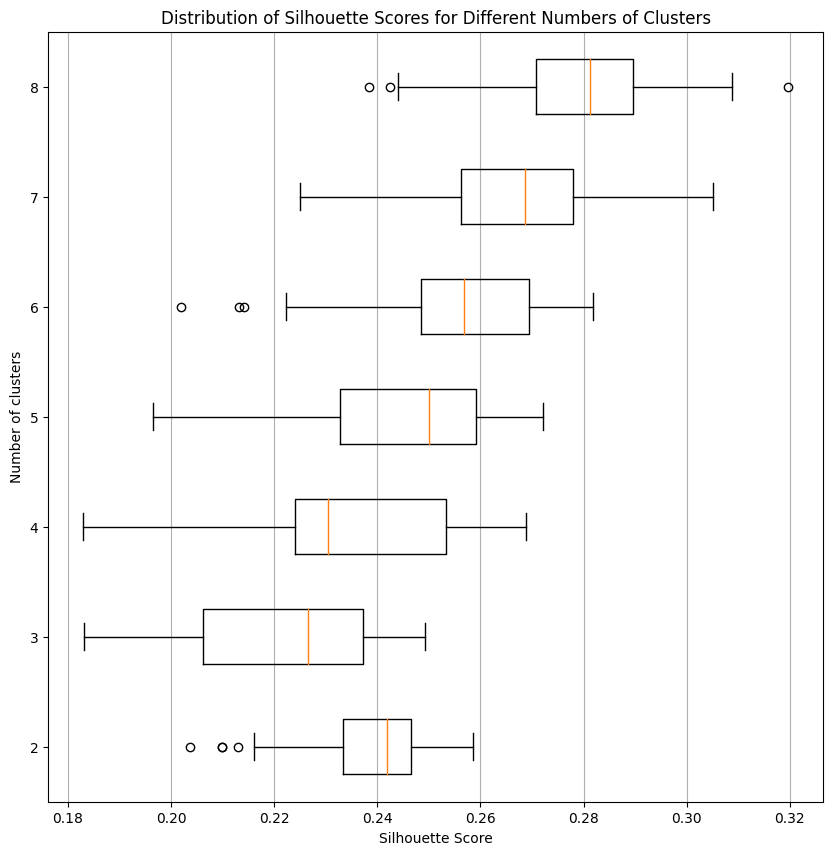

In [34]:
# Perform bootstrapped k-means clustering
n_boot = 100
silhouette_scores_boot = []

for k in k_range:
    silhouette_scores_iter = []
    for _ in range(n_boot):
        # Sample with replacement
        sample_indices = np.random.choice(range(len(MD_x)), len(MD_x), replace=True)
        sample_data = MD_x.values[sample_indices]
        
        # Fit k-means on sampled data
        kmeans = KMeans(n_clusters=k, n_init=1, random_state=1234)
        kmeans.fit(sample_data)
        silhouette_scores_iter.append(silhouette_score(sample_data, kmeans.labels_))
    
    # Append silhouette scores for each k to the list
    silhouette_scores_boot.append(silhouette_scores_iter)

# Plot vertical boxplots
plt.boxplot(silhouette_scores_boot, labels=k_range, vert=False)
plt.xlabel("Silhouette Score")
plt.ylabel("Number of clusters")
plt.title("Distribution of Silhouette Scores for Different Numbers of Clusters")
plt.grid(axis='x')
plt.show()

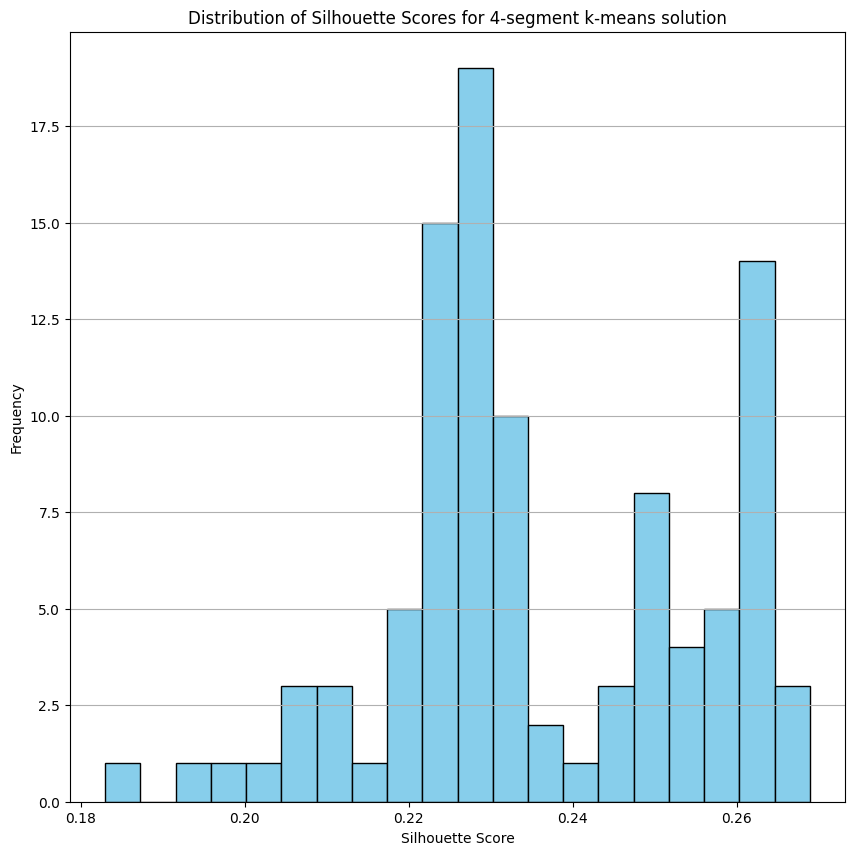

In [35]:
# Extract silhouette scores for the chosen cluster solution
chosen_k = 4
silhouette_scores_chosen_k = silhouette_scores_boot[chosen_k - 2]

# Plot histogram
plt.hist(silhouette_scores_chosen_k, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Silhouette Score")
plt.ylabel("Frequency")
plt.title(f"Distribution of Silhouette Scores for {chosen_k}-segment k-means solution")
plt.grid(axis='y')
plt.show()

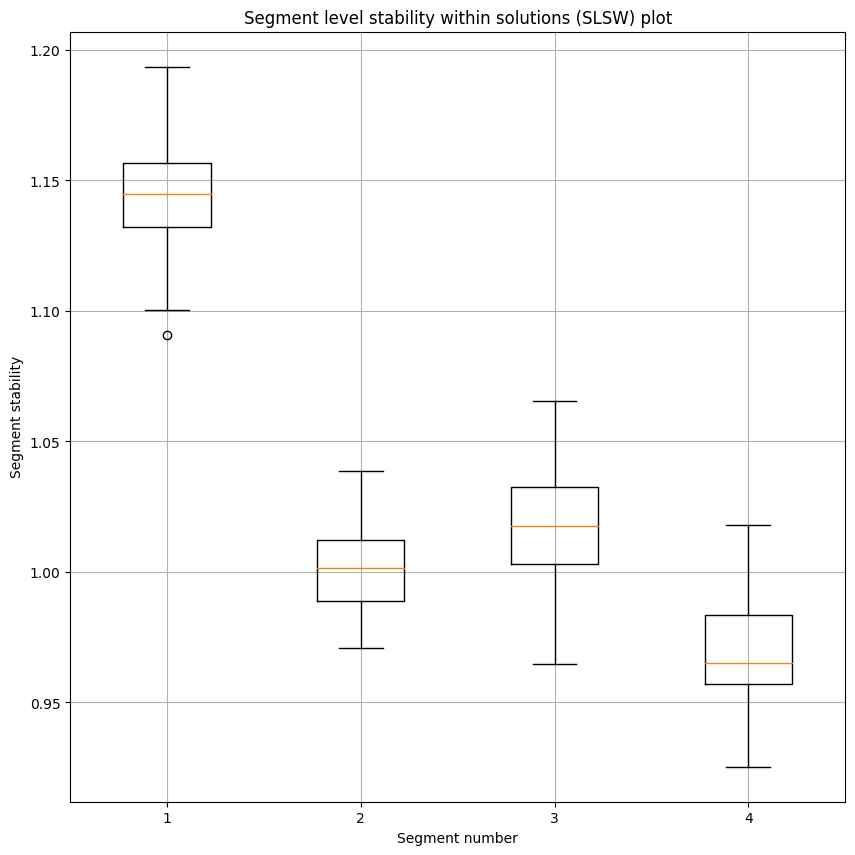

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances

def slsw_analysis(data, labels, n_boot=100):
    stability_scores = []
    n_clusters = len(np.unique(labels))
    
    if n_clusters == 1:
        return [0]  # Default stability score of 0 for a single cluster
    
    for cluster in range(n_clusters):
        stability_scores_iter = []
        for _ in range(n_boot):
            # Sample with replacement
            sample_indices = np.random.choice(range(len(data)), len(data), replace=True)
            sample_data = data[sample_indices]
            sample_labels = labels[sample_indices]
            
            # Filter data for the current cluster
            cluster_data = sample_data[sample_labels == cluster]
            
            # Calculate mean intra-cluster distance for the current cluster
            centroid = cluster_data.mean(axis=0)
            intra_cluster_distances = pairwise_distances(cluster_data, [centroid])
            stability_scores_iter.append(np.mean(intra_cluster_distances))
        
        # Append mean intra-cluster distance for the current cluster
        stability_scores.append(stability_scores_iter)
    
    return stability_scores

# Perform SLSW analysis for the chosen cluster solution
chosen_labels = KMeans(n_clusters=chosen_k, n_init=1, random_state=1234).fit(MD_x).labels_
segment_stability_scores = slsw_analysis(MD_x.values, chosen_labels)

# Plot stability plot as vertical boxplots
plt.boxplot(segment_stability_scores, labels=range(1, chosen_k + 1))
plt.xlabel("Segment number")
plt.ylabel("Segment stability")
plt.title("Segment level stability within solutions (SLSW) plot")
plt.grid(True)
plt.show()


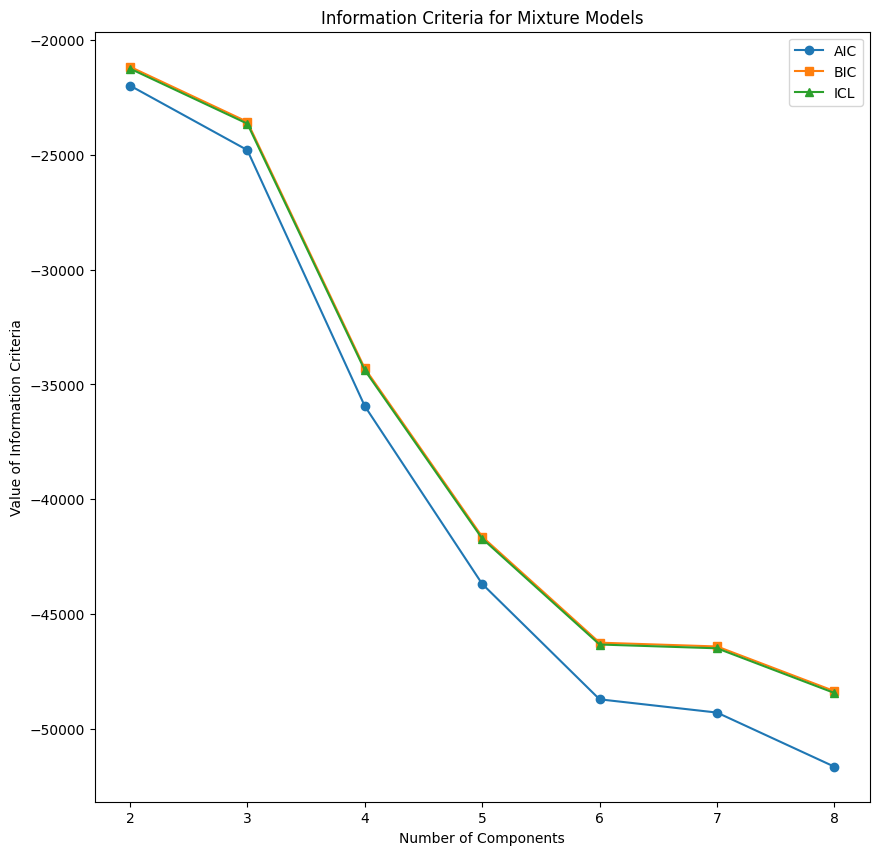

Cross-tabulation of KMeans and Mixture Clusters:
col_0    0   1   2    3
row_0                  
0      449   1  42   21
1      288  36   5   37
2        0  87   2  153
3        0   8  77  247
Log Likelihood of Gaussian Mixture Model with 4 Components: 12.580946387710531


In [37]:
# Set random seed
np.random.seed(1234)

# StepFlexmix analysis
aic = []
bic = []
icl = []
for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, n_init=10, random_state=1234)
    gmm.fit(MD_x)
    aic.append(gmm.aic(MD_x))
    bic.append(gmm.bic(MD_x))
    # Calculate ICL manually (ICL = BIC - log(n) * d)
    n_samples, n_features = MD_x.shape
    log_likelihood = gmm.score(MD_x)
    icl.append(gmm.bic(MD_x) - np.log(n_samples) * n_features)

# Plot information criteria with line markers
plt.plot(range(2, 9), aic, marker='o', label='AIC')
plt.plot(range(2, 9), bic, marker='s', label='BIC')
plt.plot(range(2, 9), icl, marker='^', label='ICL')
plt.xlabel("Number of Components")
plt.ylabel("Value of Information Criteria")
plt.title("Information Criteria for Mixture Models")
plt.legend()
plt.show()

# Get model for 4 components
gmm_m4 = GaussianMixture(n_components=4, n_init=10, random_state=1234)
gmm_m4.fit(MD_x)

# Compare kmeans and mixture models
kmeans_clusters = KMeans(n_clusters=4, n_init=10, random_state=1234).fit_predict(MD_x)
mixture_clusters = gmm_m4.predict(MD_x)
print("Cross-tabulation of KMeans and Mixture Clusters:")
print(pd.crosstab(kmeans_clusters, mixture_clusters))

# Log-likelihood comparison
print("Log Likelihood of Gaussian Mixture Model with 4 Components:", gmm_m4.score(MD_x))

In [38]:
# Convert object-type columns to appropriate data types
for column in mcdonalds.select_dtypes(include='object').columns:
    mcdonalds[column] = mcdonalds[column].astype('category')

# Now, check the data types again
print(mcdonalds.dtypes)


yummy             category
convenient        category
spicy             category
fattening         category
greasy            category
fast              category
cheap             category
tasty             category
expensive         category
healthy           category
disgusting        category
Like              category
Age                  int64
VisitFrequency    category
Gender            category
dtype: object


In [39]:
# Reverse the table of mcdonalds['Like']
like_counts = mcdonalds['Like'].value_counts().sort_index(ascending=True)
print(like_counts)


Like
+1              152
+2              187
+3              229
+4              160
-1               58
-2               59
-3               73
-4               71
0               169
I hate it!-5    152
I love it!+5    143
Name: count, dtype: int64


In [40]:
print(mcdonalds.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   yummy           1453 non-null   category
 1   convenient      1453 non-null   category
 2   spicy           1453 non-null   category
 3   fattening       1453 non-null   category
 4   greasy          1453 non-null   category
 5   fast            1453 non-null   category
 6   cheap           1453 non-null   category
 7   tasty           1453 non-null   category
 8   expensive       1453 non-null   category
 9   healthy         1453 non-null   category
 10  disgusting      1453 non-null   category
 11  Like            1453 non-null   category
 12  Age             1453 non-null   int64   
 13  VisitFrequency  1453 non-null   category
 14  Gender          1453 non-null   category
dtypes: category(14), int64(1)
memory usage: 33.4 KB
None


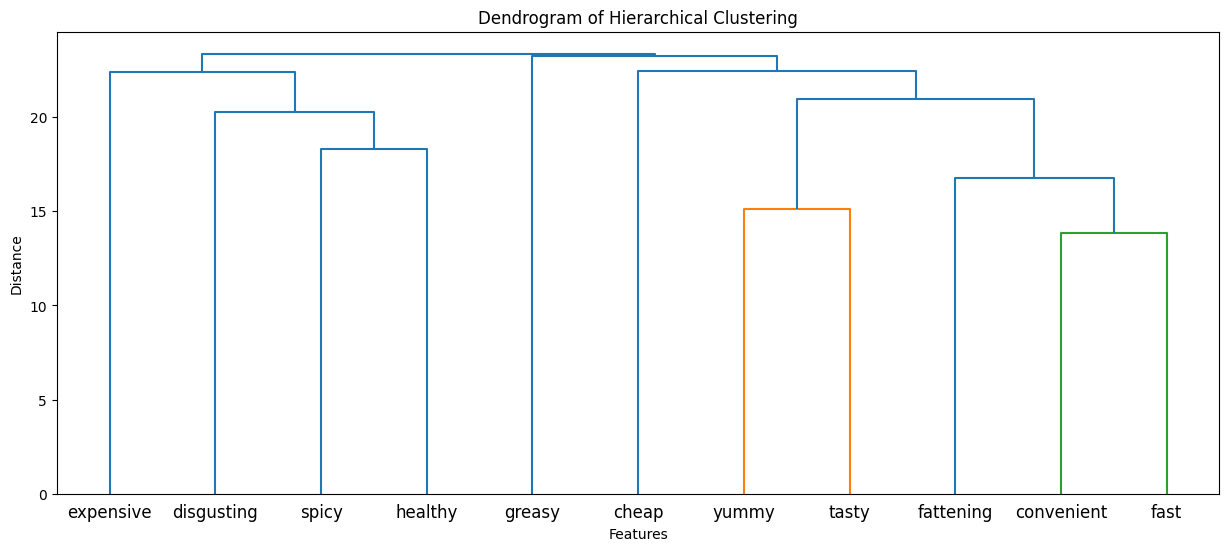

In [43]:
# Calculate pairwise distances
distances = pdist(MD_x.T)

# Perform hierarchical clustering
MD_vclust = linkage(distances)

# Cut the dendrogram to obtain four clusters
MD_k4 = fcluster(MD_vclust, 4, criterion='maxclust')

# Plot the dendrogram
plt.figure(figsize=(15, 6))
dendrogram(MD_vclust, labels=MD_x.columns)
plt.xlabel('Features')
plt.ylabel('Distance')
plt.title('Dendrogram of Hierarchical Clustering')
plt.show()

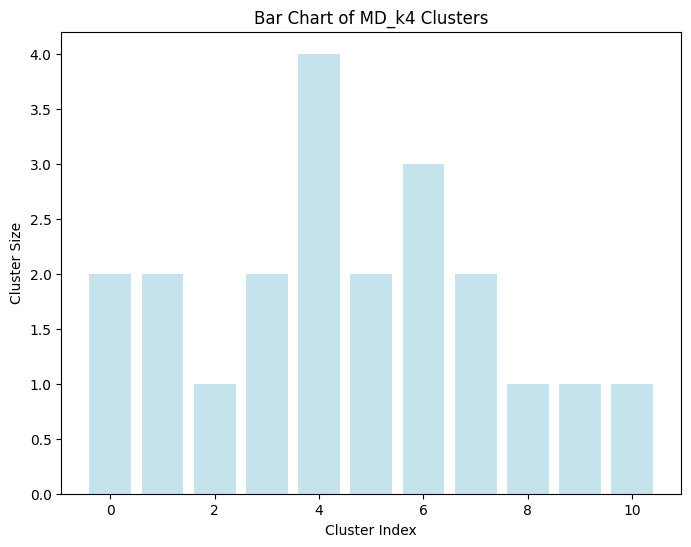

In [44]:
# Perform PCA
pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x)

# Generate a bar chart of MD_k4 clusters with shading
plt.figure(figsize=(8, 6))
plt.bar(range(len(MD_k4)), MD_k4, color='lightblue', alpha=0.7)
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Size')
plt.title('Bar Chart of MD_k4 Clusters')
plt.show()


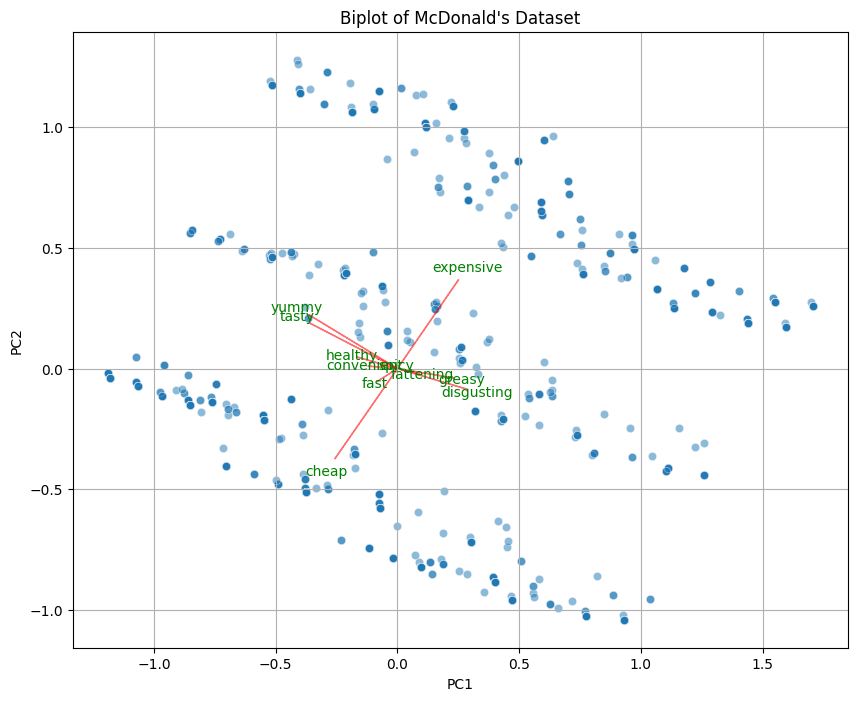

In [45]:
# Perform PCA
pca = PCA()
pca_scores = pca.fit_transform(MD_x)

# Calculate loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Plot biplot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_scores[:, 0], y=pca_scores[:, 1], alpha=0.5)
for i, column in enumerate(MD_x.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.5)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, column, color='g', ha='center', va='center')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of McDonald\'s Dataset')
plt.grid(True)
plt.show()

In [46]:
# Get the cluster labels
k4 = kmeans.labels_


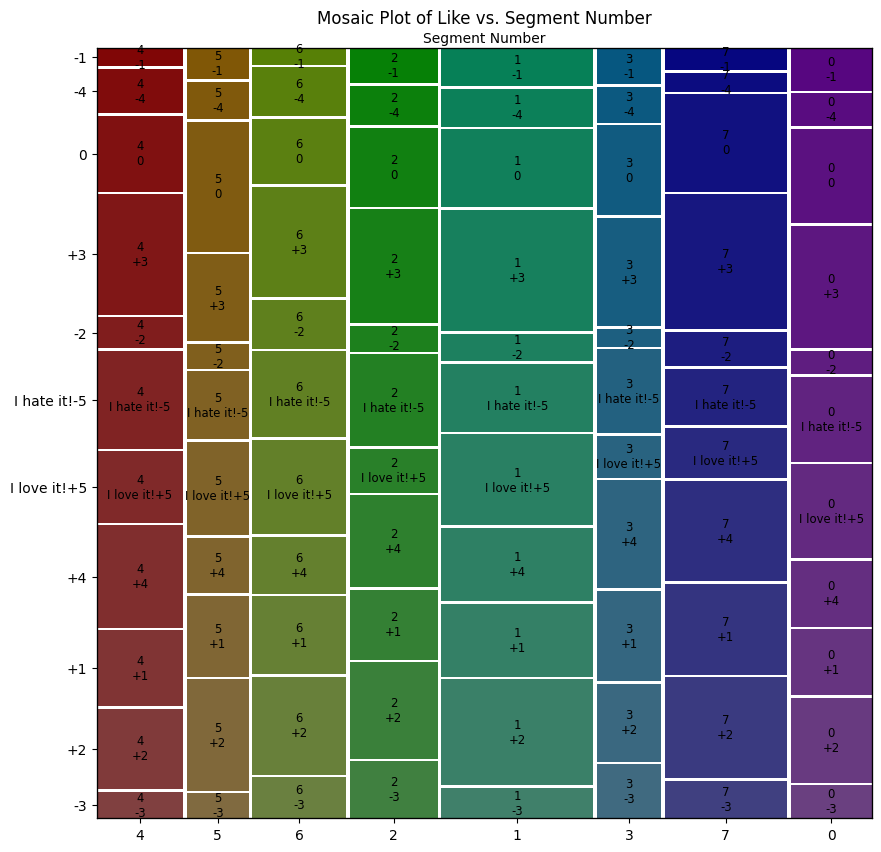

In [47]:
# Combine cluster labels with 'Like' column
data = pd.DataFrame({'k4': k4, 'Like': mcdonalds['Like']})

# Plot the mosaic plot
mosaic(data, ['k4', 'Like'], title='Mosaic Plot of Like vs. Segment Number')
plt.xlabel('Segment Number')
plt.ylabel('Like')
plt.show()

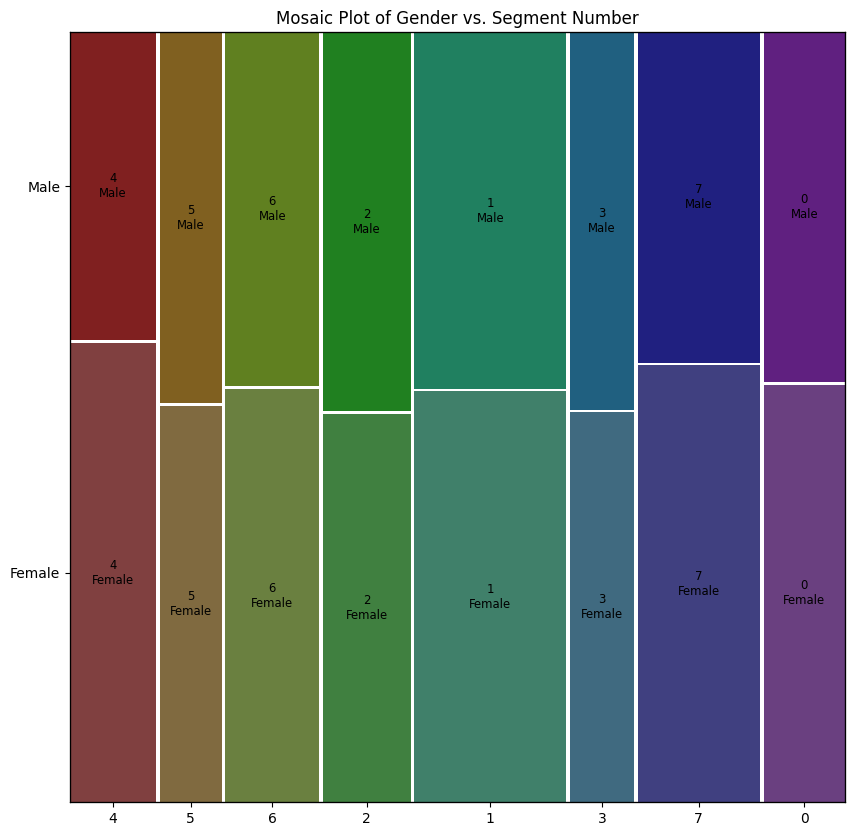

In [48]:
# Combine cluster labels with 'Gender' column
data = pd.DataFrame({'k4': k4, 'Gender': mcdonalds['Gender']})

# Plot the mosaic plot
mosaic(data, ['k4', 'Gender'], title='Mosaic Plot of Gender vs. Segment Number')
plt.show()

In [49]:
# Convert categorical variables to one-hot encoding
mcdonalds_encoded = pd.get_dummies(mcdonalds, columns=['Gender'])

# Display the first few rows of the encoded DataFrame
print(mcdonalds_encoded.head())

  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   
3   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes        No      No   
4    No        Yes    No       Yes    Yes  Yes   Yes    No        No     Yes   

  disgusting Like  Age      VisitFrequency  Gender_Female  Gender_Male  
0         No   -3   61  Every three months           True        False  
1         No   +2   51  Every three months           True        False  
2         No   +1   62  Every three months           True        False  
3        Yes   +4   69         Once a week           True        False  
4         No   +2   49        Once a month          False         True  


In [50]:
# Assign cluster labels to the mcdonalds_encoded DataFrame
mcdonalds_encoded['k4'] = k4




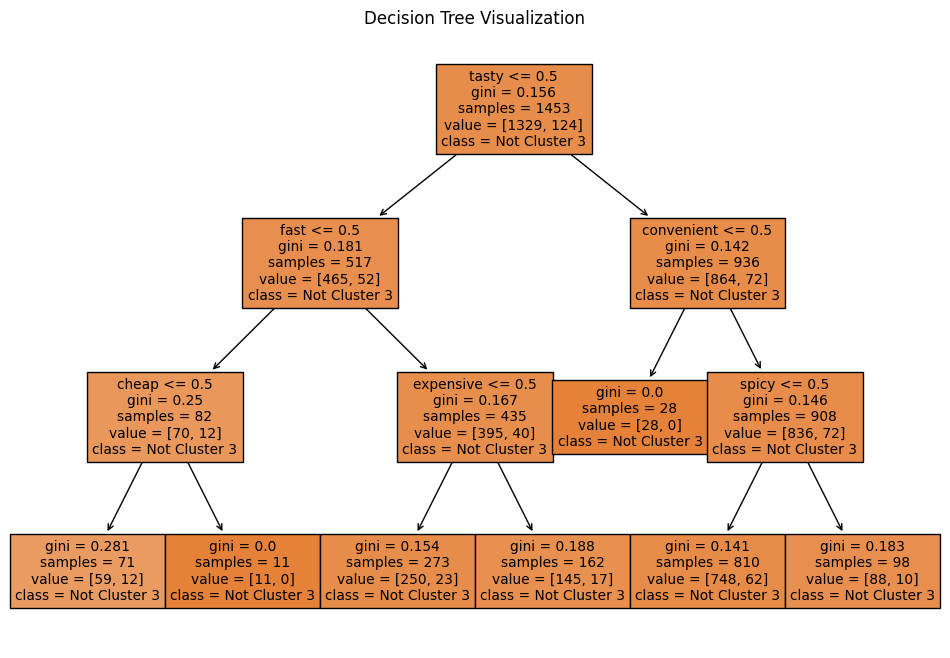

In [51]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X)

# Fit the decision tree classifier
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_encoded, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X_encoded.columns, class_names=['Not Cluster 3', 'Cluster 3'], filled=True)
plt.title('Decision Tree Visualization')
plt.show()

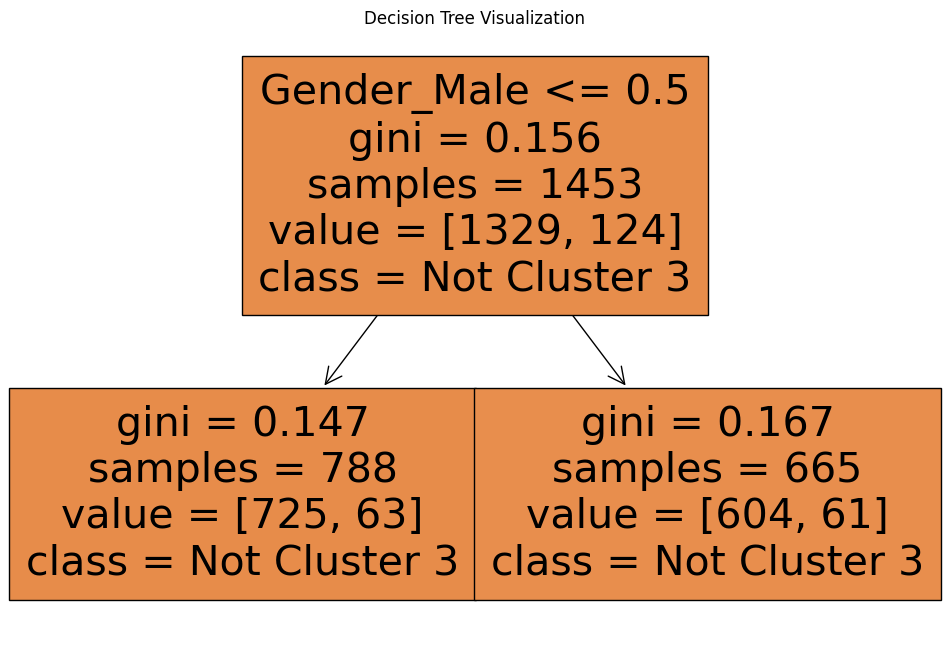

In [52]:

# Define the features and target variable
X = mcdonalds_encoded[['Gender_Female', 'Gender_Male']]
y = (k4 == 3).astype(int)  # Convert k4 to binary variable indicating cluster 3

# Fit the decision tree classifier
tree = DecisionTreeClassifier(max_depth=3)  # Limiting depth for better visualization
tree.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['Not Cluster 3', 'Cluster 3'], filled=True)
plt.title('Decision Tree Visualization')
plt.show()